In [148]:
import os 
import glob
import pathlib
import pickle
import random
import pprint

import matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import core.helper.helper_func as hf
from core.model.CrossAttention import CrossAttention
from core.dataset.Epic_pad_Dataset import Epic_pad_Dataset
from core.helper.helper_func import get_bbox_features,evaluate_mAP,Logger,evaluate_k, compute_F1

experiment_dir = "results/epic_kitchens_results/"
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(glob.glob(experiment_dir+'*/'))

newest_experiment = max(glob.glob(experiment_dir+'*/'), key=os.path.getmtime)

n = 12
nth_experiment = sorted(glob.glob(experiment_dir+'*/'), key=os.path.getmtime)[-n]


[   'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_20_01_05/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_18_05_21_58/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_18_05_23_31/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_19_52_31/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_20_03_17/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_19_45_50/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_19_50_33/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_18_05_24_56/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_18_20_30_02/',
    'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_19_20_12_48/',
    'results/epic_kitchens_results/EpicKitchens_pa

In [172]:
chosen_experiment = newest_experiment

In [173]:
files = glob.glob(chosen_experiment + "*")
print(files)
with open(chosen_experiment+"config.txt", 'r') as f:
    pp.pprint(f.read())

['results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/config.txt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/batch_loss.npy', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/model_loss.npy', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/model_MAP.npy', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/model_0_1000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/model_0_2000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/model_0_3000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/model_0_4000.pt', 'results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/model_0_5000.pt']
("Namespace(comment='', idx_GPU=1, is_w2v_map=True, la

Final_mAP: 0.2390695067264575
Final_loss: 6.617473242664337
Checkpoint loss graph


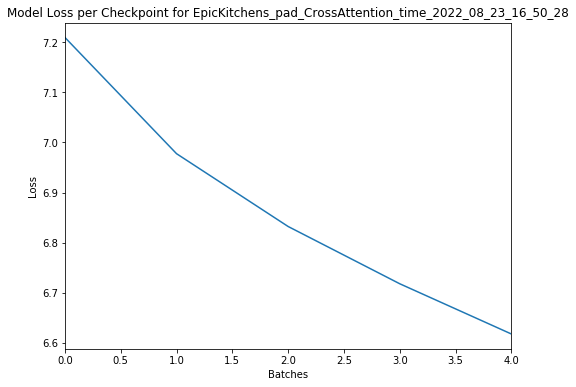

In [174]:
mAP = np.load(chosen_experiment + "model_MAP.npy")
epoch_loss = np.load(chosen_experiment + "model_loss.npy")
batch_loss = np.load(chosen_experiment + "batch_loss.npy") if os.path.exists(chosen_experiment + "batch_loss.npy") else np.array([])

print("Final_mAP: {}".format(mAP[-1]))
print("Final_loss: {}".format(epoch_loss[-1]))

experiment_name = os.path.basename(os.path.normpath(chosen_experiment))

if np.any(epoch_loss):
    print("Checkpoint loss graph")
    s_e_loss = pd.Series(epoch_loss, name="Checkpoint Loss (28 images)").plot(figsize=(8,6), title="Model Loss per Checkpoint for {}".format(experiment_name))
    s_e_loss.set_xlabel("Batches")
    s_e_loss.set_ylabel("Loss")
    f_e = s_e_loss.get_figure()
    f_e.savefig("results/{}_checkpoint_loss.png".format(experiment_name))



Batch loss graph


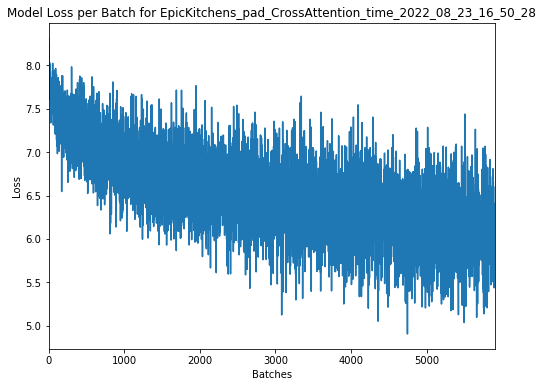

In [175]:
if np.any(batch_loss):
    print("Batch loss graph")
    s_b_loss = pd.Series(batch_loss, name="Batch Loss (28 images)").plot(figsize=(8,6), title="Model Loss per Batch for {}".format(experiment_name))
    s_b_loss.set_xlabel("Batches")
    s_b_loss.set_ylabel("Loss")
    f_b = s_b_loss.get_figure()
    f_b.savefig("results/{}_batch_loss.png".format(experiment_name))

In [176]:
with open('./w2v/epic_kitchens_act_obj.pkl','rb') as f:
    content = pickle.load(f)

    
batch_size = 30
val_Dataset = Epic_pad_Dataset('validation',content)
subset_val = torch.utils.data.Subset(val_Dataset, random.sample(list(range(len(val_Dataset))), len(val_Dataset) // 5))
test_dataloader = torch.utils.data.DataLoader(subset_val,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)

last_model = max(glob.glob(chosen_experiment +'*.pt'), key=os.path.getmtime)
print(last_model)

idx_gpu = 2
device = torch.device("cuda:{}".format(idx_gpu) if torch.cuda.is_available() else "cpu")


model = CrossAttention(dim_f=2048,dim_v=300,
                       init_w2v_a=content['actions_w2v'],init_w2v_o=content['objects_w2v'],
                       Z_a=content['Z_a'],Z_o=content['Z_o'],
                       trainable_w2v_a = True,trainable_w2v_o = True,
                       normalize_V_a = True, normalize_V_o = True, normalize_F = True,
                       label_type = "interaction", grid_size=val_Dataset.grid_size,
                       lamb = -1, is_w2v_map = True)

model.to(device)
model.load_state_dict(torch.load(last_model,map_location=device))
model.eval()

len features validation: 71278
results/epic_kitchens_results/EpicKitchens_pad_CrossAttention_time_2022_08_23_16_50_28/model_0_5000.pt
RELU
RELU
RELU
------------------------------
Configuration
lamb -1
normalize V_a
normalize V_o
normalize F


CrossAttention(
  (w2v_map): ResNet(
    (linear1): Linear(in_features=300, out_features=60, bias=True)
    (linear2): Linear(in_features=60, out_features=300, bias=True)
  )
  (log_softmax_func): LogSoftmax()
  (bce_criterion): BCEWithLogitsLoss()
  (ce_criterion): CrossEntropyLoss()
  (object2actor_gaussian): NeuralNet(
    (linear1): Linear(in_features=2350, out_features=300, bias=True)
    (linear2): Linear(in_features=300, out_features=4, bias=True)
  )
  (actor2object_gaussian): NeuralNet(
    (linear1): Linear(in_features=2350, out_features=300, bias=True)
    (linear2): Linear(in_features=300, out_features=4, bias=True)
  )
)

In [6]:
AP,all_preds,all_labels=evaluate_mAP(test_dataloader,model,device)

100%|██████████| 476/476 [05:35<00:00,  1.42it/s]


realistic


In [56]:
print("Validation AP: {}".format(np.mean(AP)))
y_pred_y_true = [(np.argmax(x),np.argmax(y)) for i,(x,y) in enumerate(zip(all_preds, all_labels))]
matching_indices = [i for i,(x,y) in enumerate(zip(all_preds, all_labels)) if np.argmax(x) == np.argmax(y)]
max_values_pred = [(i, np.argmax(x), np.max(x)) for i,x in enumerate(all_preds)]
correct_max_values_pred = [max_values_pred[i] for i in matching_indices]

Validation AP: 0.27634529147982073


In [18]:
hoi_df = pd.read_csv("data/epic_kitchens/epic_kitchens_hoi.csv")
noun_df = pd.read_csv("data/epic_kitchens/epic-kitchens-100-annotations/EPIC_100_noun_classes.csv")
action_df = pd.read_csv("data/epic_kitchens/epic-kitchens-100-annotations/EPIC_100_verb_classes.csv")

In [40]:
hoi_df["verb_key"] = np.array([action_df["key"][action_df["id"] == i].values for i in hoi_df["verb_class"].values])

In [41]:
hoi_df["noun_key"] = np.array([noun_df["key"][noun_df["id"] == i].values for i in hoi_df["noun_class"].values])

In [171]:
subset_val[matching_indices[0]][1].shape

(2048, 17, 17)